# 1.引言

通过前面两篇文章带你实现多头注意力和带你构建TransformerBlock，我们基本已经构建完了一个大语言模型的关键模块，本节我们将基于这些模块构建出一个能够运行的GPT Model，并用这个Model类完成从序列文本输入到序列文本输出的整个流程。整个流程如下所示：

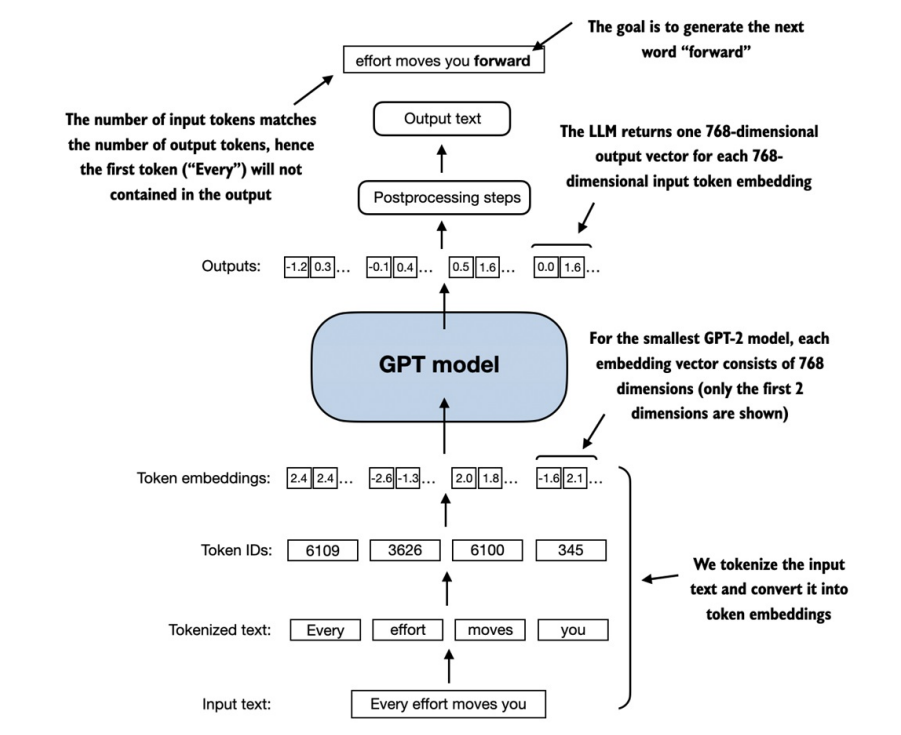

- 序列化：用户输入的文本首先通过分词器处理，转化为一系列的token ID；
- 嵌入：离散的token ID序列经过嵌入层（embedding layer）处理后，为每个token生成对应的连续向量表示；
- 推理：将这些序列向量输入模型，经过一系列连续的矩阵乘法运算，模型将基于已有的上下文信息预测出下一个token的概率分布；
- 选词：根据概率分布，模型选取下一个最可能的token，从而生成连贯的输出token序列。
- 反序列化：通过分词器的反序列化，将选出的token ID转换回可读的文本形式。

# 2.模型架构组成
我们将要构建的LLM架构组成如下：
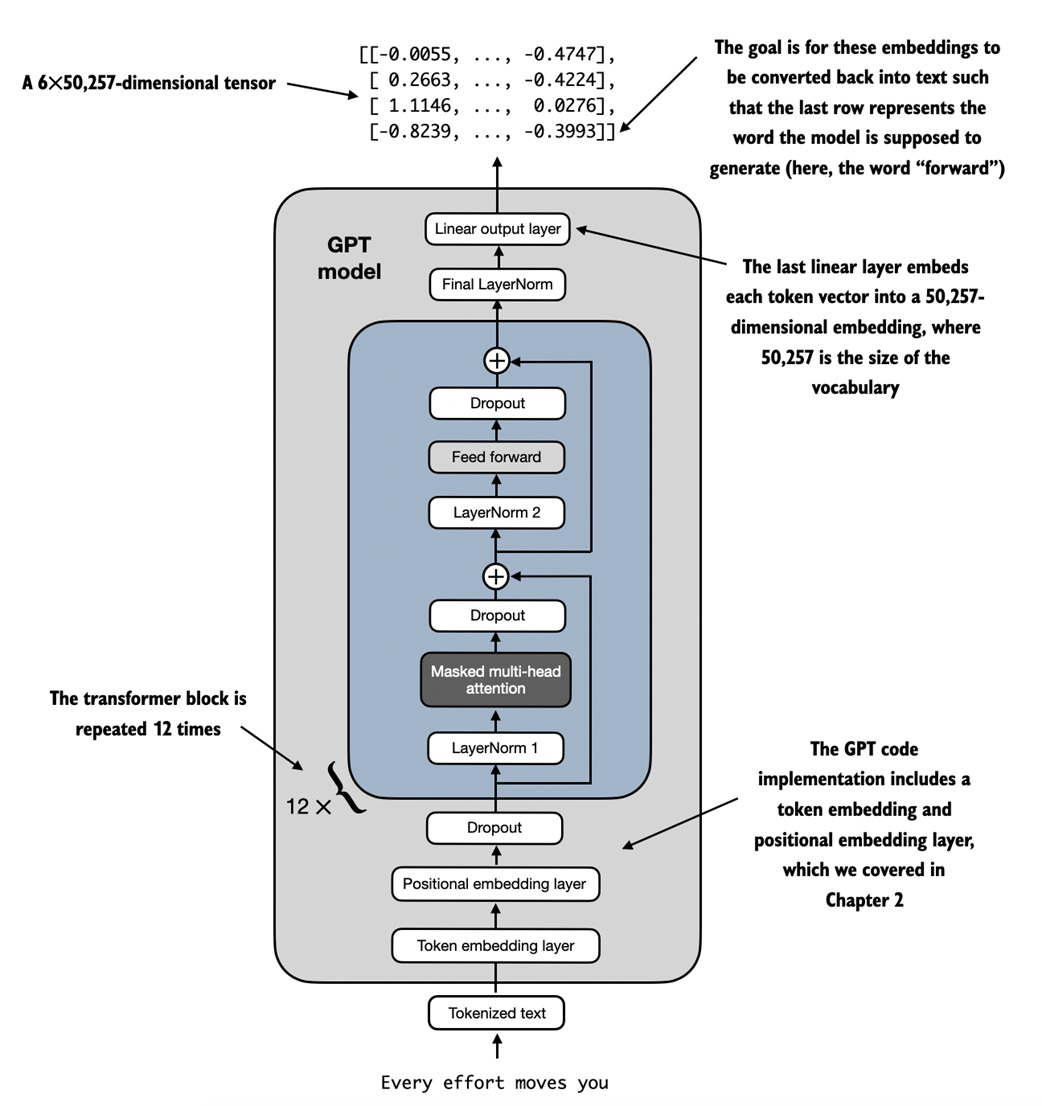
- 嵌入层（embedding layer）: 用于将tokenID序列转换为连续向量表示；
- 丢弃层（embedding dropout）: 用于在训练过程中随机丢弃部分嵌入向量，减少模型的过拟合现象；
- 解码层（decode layers）: 由多个TransformerBlock堆叠而成，负责处理输入并逐步得到序列的上下文向量。
- 最终归一化（final norm）: 对所有输出进行最一化处理，确保输出数值在一个适当的范围内；
- 输出层（output layer）: 将模型的最终向量转换为token的概率分布；

下面，我们将一步一步创建出每一层，并用一个输入数据演示每一层运算后的输出效果

## 2.1 准备工作
首先，我们引入前面已经构建的transformer block组件，其它组件包括多头自注意力也已经包含在此脚本中。

In [3]:
%run transformer.py

定义一套配置项，用于设置模型的基本结构，包括：

- vocab_size: 词表大小, 这里使用分词器训练的词表大小32000;
- emb_dim: 嵌入层维度，设置为4是为了演示方便；
- n_heads: 多头数量，emb_dim必须是n_heads的整数倍，这里设置为2；
- context_length: 上下文长度, 为了演示方便，设置为10;
- n_layers: 解码层数；
- drop_rate: 训练中dropout层随机丢弃的参数比例；

In [19]:
config = {
    "vocab_size": 32000,
    "emb_dim": 4,
    "n_heads": 2,
    "context_length": 10,
    "n_layers":2,
    "drop_rate": 0.1,
    "qkv_bias": False
}

用随机数创建一个batch_size=2, seq_len=4的小批量输入，以这个数据为例来演示模型的前向传播过程。

In [8]:
inputs = torch.randint(low=0, high=config['vocab_size'], size=(2, 4))
b, seq_len = inputs.shape
print(f"batch_size:{b}, seq_len: {seq_len}")
print("inputs:", inputs)

batch_size:2, seq_len: 4
inputs: tensor([[27500, 22562, 14058,  1004],
        [30204,  8487, 19749,  1916]])


### 创建过程
#### 第一步：创建嵌入层
根据配置创建一个词表大小为32000、嵌入维度为4的嵌入层，并对小批量输入序列进行向量嵌入。

In [12]:
# 参数1是词表大小
# 参数2是嵌入向量维度
token_emb = nn.Embedding(config['vocab_size'], config['emb_dim'])
x = token_emb(inputs)
x

tensor([[[ 0.3371,  1.2344, -1.1313,  0.3652],
         [-1.0204,  0.4343,  2.0783,  0.1373],
         [ 0.1094, -0.7642, -0.6669,  1.8114],
         [ 0.0789,  0.6425,  1.8133, -0.8665]],

        [[-0.6013,  0.0516,  1.0816, -1.8508],
         [ 1.7385, -0.9974, -0.5845,  0.2254],
         [-0.4687,  0.6138, -0.8672,  0.4010],
         [-0.9955,  0.7731, -0.9363,  0.4922]]], grad_fn=<EmbeddingBackward0>)

#### 第二步：创建一个丢弃层
drop_rate=0.1表示每次训练时约有10%的嵌入会被丢弃。 

In [14]:
drop = nn.Dropout(config['drop_rate'])
x = drop(x)
x

tensor([[[ 0.4162,  1.5240, -1.3967,  0.0000],
         [-0.0000,  0.5362,  0.0000,  0.1695],
         [ 0.0000, -0.9435, -0.0000,  2.2363],
         [ 0.0000,  0.7932,  0.0000, -1.0698]],

        [[-0.0000,  0.0000,  1.3353, -0.0000],
         [ 2.1463, -1.2313, -0.7216,  0.2783],
         [-0.5786,  0.0000, -1.0706,  0.4951],
         [-1.2290,  0.9544, -0.0000,  0.6076]]], grad_fn=<MulBackward0>)

#### 计算位置编码
由于解码层中的注意力得分计算需要使用位置编码，这里先根据context_length计算出0-9每个位置的旋转编码，然后截取此次输入长度（seq_len=4)范围内的部分作为输入序列inputs的位置编码。

In [15]:
pos_cis = precompute_pos_cis(config['emb_dim'] // config['n_heads'], config['context_length'])
pos_cis = pos_cis[:seq_len]
pos_cis

tensor([[ 1.0000+0.0000j],
        [ 0.5403+0.8415j],
        [-0.4161+0.9093j],
        [-0.9900+0.1411j]])

#### 第四步：创建解码层

根据n_layers参数循环构建出指定数量的解码层，并使用此解码层序列对输入向量作特征计算，最终得到一个能表示输入序列特征的上下文向量。

> 注：每一个解码层是前文讲过的TransformerBlock块实例，里面封装了层归一化、多头注意力、前馈神经网络、残差连接等transformer核心组件。

In [20]:
decode_layers = nn.Sequential(*[
    TransformerBlock(**config) for _ in range(config['n_layers'])
])
for i, block in enumerate(decode_layers):
    x, _ = block(x, pos_cis)
print(x)

tensor([[[ 1.2940,  1.4694, -1.2891,  0.3754],
         [ 0.3630,  0.3538,  0.0524,  0.5893],
         [-0.3356, -1.7423,  0.1947,  2.9900],
         [-0.1414,  0.4728, -0.1359, -0.3609]],

        [[-0.2713, -1.3778,  2.3737,  0.7345],
         [ 1.5878, -2.6446,  0.0312,  0.4995],
         [-1.1157, -0.1633, -0.5997,  1.6125],
         [-1.4937,  0.5304,  0.0659,  1.5778]]], grad_fn=<AddBackward0>)


#### 第五步：创建最终归一化层，并对解码层计算出的上下文向量进行归一化操作。

In [24]:
final_norm = LayerNorm(config['emb_dim'])
x = final_norm(x)
x

tensor([[[ 0.5046,  1.3680, -0.6915, -1.1811],
         [ 0.9584,  0.9855, -0.6405, -1.3034],
         [-0.9812,  0.8617, -1.0096,  1.1291],
         [ 0.5745,  1.2485, -1.3850, -0.4380]],

        [[-1.1803,  0.8980, -0.7970,  1.0794],
         [-1.1346,  1.0197, -0.8553,  0.9702],
         [ 0.4595,  0.9986, -1.6582,  0.2001],
         [ 0.3555,  1.0718, -1.6369,  0.2096]]], grad_fn=<AddBackward0>)

> 可以看到，经过归一化后，每个张量的数值范围明显收窄。

#### 第六步：创建线性层（Linear Layer），用于将最后的特征映射到词汇表的大小，生成每个token的预测概率。

In [25]:
out_head = nn.Linear(config['emb_dim'], config['vocab_size'])
logits = out_head(x)
logits, logits.shape

(tensor([[[ 1.0697, -0.2376,  0.6884,  ...,  0.2951,  0.1838, -0.7634],
          [ 0.9066, -0.2743,  0.8191,  ...,  0.2023,  0.3008, -0.7332],
          [ 1.0717,  0.4561, -0.0919,  ..., -0.1990, -0.2770, -0.5459],
          [ 1.2629, -0.0272,  0.8214,  ..., -0.3060,  0.5296, -0.7741]],
 
         [[ 1.0198,  0.4456, -0.2198,  ..., -0.0202, -0.4511, -0.5262],
          [ 1.0780,  0.4114, -0.1607,  ..., -0.0188, -0.3955, -0.5549],
          [ 1.2776,  0.1603,  0.7601,  ..., -0.6249,  0.5940, -0.7280],
          [ 1.2990,  0.1638,  0.7211,  ..., -0.5828,  0.5503, -0.7310]]],
        grad_fn=<ViewBackward0>),
 torch.Size([2, 4, 32000]))

# 3.模型封装
## 3.1 模型配置封装
前面用字典形式创建的模型配置虽然方便，但不够规范，由于兼容transformer库已经成为开源模型的一个事实标准，所以我们也采用结构化的方式来定义模型配置。具体如下 ：

- 使用transformers.PretrainedConfig作为模型配置的基类（transformers库的标准）。
- 所有配置参数使用类的成员属性显式定义，这样可以提供默认值，并限制类型。
- 定义一个类属性字段model_type，作为模型独一无二的类型标识，类似通义千问的qwen一样，用以和transformers库中其它类型的模型区分。

In [26]:
class GPTConfig(PretrainedConfig):
    model_type = "minigpt"
    
    def __init__(self, **kwargs):
        super().__init__()
        
        self.context_length = kwargs.get('context_length', 1024)
        self.vocab_size = kwargs.get('vocab_size', 32000)
        self.emb_dim = kwargs.get('emb_dim', 768)
        self.drop_rate = kwargs.get('drop_rate', 0.1)
        self.n_layers = kwargs.get('n_layers', 12)
        self.n_heads = kwargs.get('n_heads', 12)
        self.qkv_bias = kwargs.get('qkv_bias', False)
        
cfg = GPTConfig()
cfg

GPTConfig {
  "context_length": 1024,
  "drop_rate": 0.1,
  "emb_dim": 768,
  "model_type": "minigpt",
  "n_heads": 12,
  "n_layers": 12,
  "qkv_bias": false,
  "transformers_version": "4.36.2",
  "vocab_size": 32000
}

> 上面的各个配置项的默认值，就是我们将要构建的模型目标结构，这里采用768维的向量嵌入，12个解码层，12个注意力头，1024的上下文长度。

## 3.2 模型结构封装
我们最终创建一个名为MiniGPT的模型类，为了与HuggingFace的transformers库兼容，该类需要满足两点：

1. 继承自PreTrainedModel
2. 采用PreTrainedConfig类型的配置对象作为构造函数参数。
> 标准化的基类还提供了以下好处：
> - 可以直接使用from_pretrained和save_pretrained方法来加载模型权重和保存模型权重，不用关心权重存储细节；
> - 可以集中管理与模型结构相关的超参数，使得模型的构建代码非常简洁一致，与便于配置的扩展。

具体操作就是将上面嵌入层、dropout层、解码层、最终归一化层、输出层的创建代码封装到构造方法中。

In [27]:
class MiniGPT(PreTrainedModel):
    config_class = GPTConfig

    def __init__(self, config: GPTConfig):
        super().__init__(config)
        self.context_length = config.context_length
        self.num_heads = config.n_heads
        self.n_layers = config.n_layers
        self.token_emb = nn.Embedding(config.vocab_size, config.emb_dim)
        self.drop_emb = nn.Dropout(config.drop_rate)
        
        pos_cis = precompute_pos_cis(config.emb_dim // config.n_heads, config.context_length)
        self.register_buffer("pos_cis", pos_cis, persistent=False)
        self.decode_layers = nn.Sequential(*[
            TransformerBlock(**(config.to_dict())) for _ in range(config.n_layers)
        ])
        
        self.final_norm = LayerNorm(config.emb_dim)
        self.out_head = nn.Linear(config.emb_dim, config.vocab_size)

## 3.3 模型推理封装
将前面各个层的运算代码封装到forward方法中。

In [28]:
def forward(self, inputs:torch.Tensor, **kwargs):
    b, seq_len = inputs.shape
    pos_cis = self.pos_cis[:seq_len]
    x = self.token_emb(inputs)
    x = self.drop_emb(x)

    for i, block in enumerate(self.decode_layers):
        x, _ = block(x, pos_cis)

    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

setattr(MiniGPT, "forward", forward)

> Tips1：定义模型对外的forward时，最好预留一个kwargs参数，用于接受一些训练器额外传递的参数，例如注意力掩码、kv_cache开关等，如果没有kwargs，python方法接收未声明的参数时会报错。

> Tips2：很多文章都提到dropout只会用在训练模式下，但上面的drop_emb方法我们并不需要显式加模式判断，原因在于Dropout组件内部实现了train()和eval()模式的判断，只有在train模式下才会进行随机丢弃。有相同行为的组件还有BatchNorm，只有train模式下才会使用批次统计信息，推理模式下会使用整个训练数据的统计信息。

## 3.4 模型测试
下面我们初始化这个模型，以随机初始化的批次序列来查看模型的输出。

In [29]:
torch.manual_seed(123)
batch = torch.randint(low=0, high=cfg.vocab_size, size=(2, 4))
model = MiniGPT(cfg)
logits = model(batch)

print("inputs: ", batch)
print("output shape:", logits.shape)
print("outputs:", logits)

inputs:  tensor([[16382,  7789, 31102, 12610],
        [15580, 31842,  6886, 23057]])
output shape: torch.Size([2, 4, 32000])
outputs: tensor([[[ 0.6843,  0.1193,  0.1771,  ...,  0.1656,  0.7182, -0.1579],
         [ 0.3973,  0.2587,  0.8052,  ...,  0.4471,  0.2243,  0.0963],
         [-0.3390, -0.3508, -0.2874,  ..., -0.4334,  1.0599, -0.5160],
         [ 0.4778,  0.1755, -0.6124,  ..., -0.4519,  0.0903,  0.2796]],

        [[ 0.3370, -0.2318,  0.2040,  ..., -1.0603, -0.4211,  0.5172],
         [-0.0364, -0.4018,  0.4197,  ..., -0.4230,  0.3542, -0.3473],
         [ 0.5889, -0.4255, -0.1676,  ..., -0.8449,  0.1559, -0.3889],
         [ 0.7398,  0.2484,  1.1383,  ..., -0.1338, -0.1800,  0.0232]]],
       grad_fn=<ViewBackward0>)


通过model.parameters()可以计算模型的参数量。

In [32]:
total_params = sum(param.numel() for param in model.parameters())
total_params

134212352

此模型有1.34亿个参数。以32位浮点数精度来计算模型参数的内存需求：

In [33]:
total_size_bytes = total_params * 4
print(f"total_size of the model: {total_size_bytes/(1024*1024):.2f}MB")

total_size of the model: 511.98MB


# 4.生成文本序列
我们对模型的需求是输出一个完整的文本序列，而上面构建的MiniGPT仅仅是输出下一个token的logits。为了生成一个序列我们需要对GPTModel进行多次迭代调用，每次迭代得到一个token，再把这个token添加到序列中继续迭代，整个过程类似下图所示。
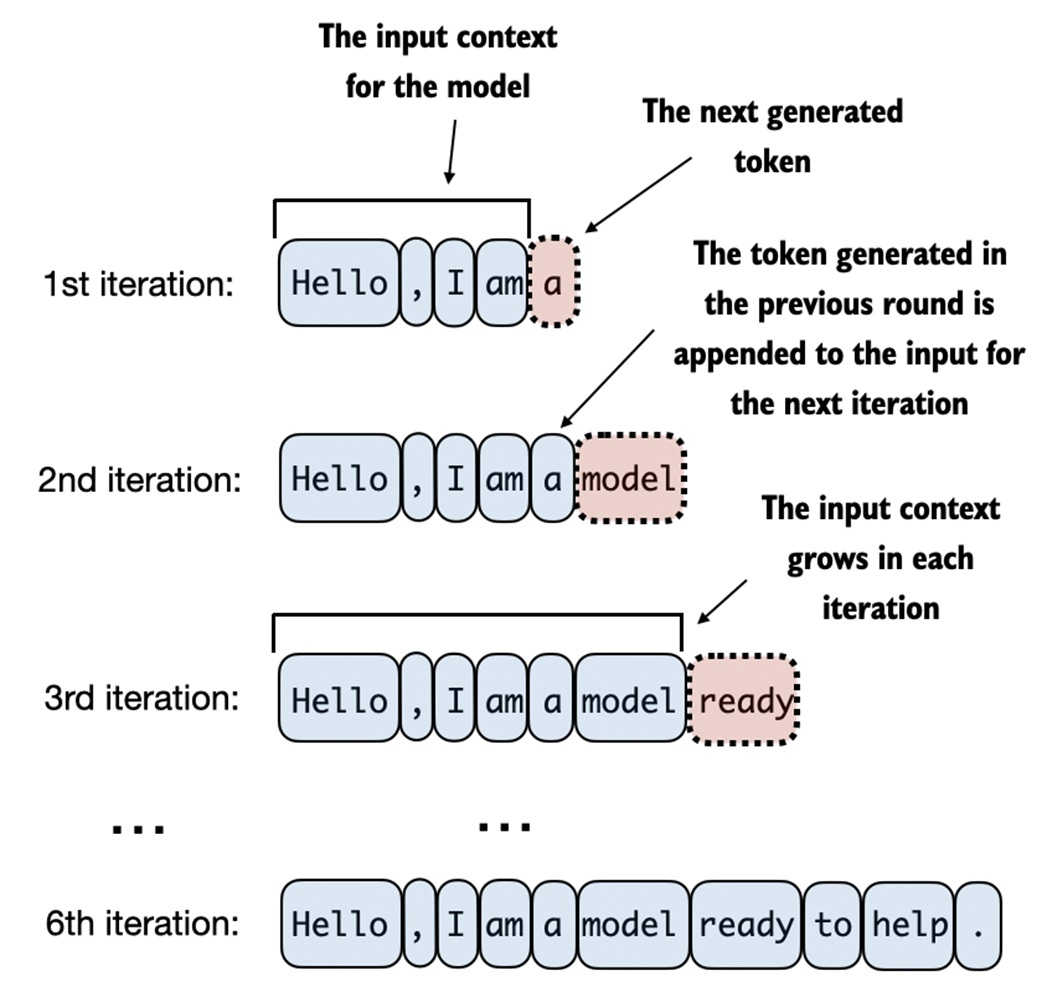
为此，需要编写一个generate函数来完成一个序列的预测。

In [37]:
@torch.inference_mode
def generate(self, input_ids, max_length=512, eos_token_id=-1):
    """序列生成函数"""
    # 创建batch长度的全零值，用作停止推理的判断。
    eos_reached = torch.zeros(len(input_ids), dtype=torch.bool, device=input_ids.device)
    for _ in range(max_length):
        # 如果生成序列过程中超出上下文长度，则由后往前截取context_length个token。
        context_ids = input_ids[:, -self.context_length:]
        with torch.no_grad():
            out = self(context_ids)  # 这里的self是什么?
        
        # 取每个序列的最后一个token的输出向量作为logits，shape=（batch_size, vocab_size）
        logits = out[:, -1, :]
        # 使用softmax函数将logits转换为下一个token的概率分布，shape仍是: batch, vocab_size
        probs = torch.softmax(logits, dim=-1)
        # 解码策略：取概率最大的作为next_token_ids，形状变为：batch, 1
        next_token_ids = torch.argmax(probs, dim=-1, keepdim=True)
        # 将next_token_id连接到下一个token的结尾， 形状变为：batch, n_tokens+1
        input_ids = torch.cat((input_ids, next_token_ids), dim=1)
        
        # 更新 eos_reached，需要所有batch都推理出eos_token，才会终止推理
        eos_reached |= (next_token_ids.squeeze(-1) == eos_token_id)
        if eos_reached.all(): break

    return input_ids

setattr(MiniGPT, "generate", generate)
        

上面函数中for循环内部的代码逻辑，是在完成一个token的预测，代码逻辑可以按照下图所示的流程来辅助理解：
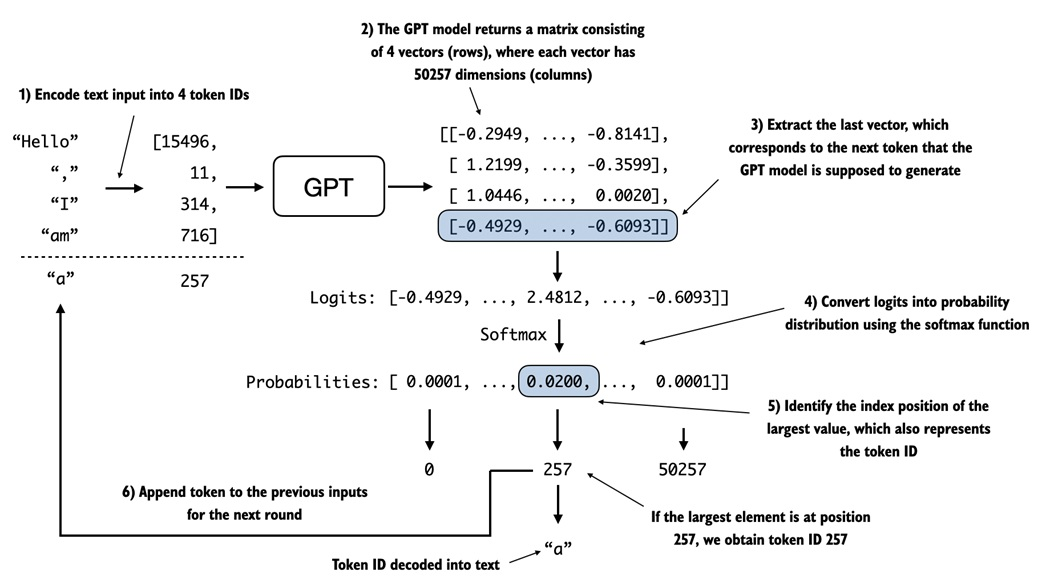
在测试这个generate函数之前，需要先创建一个Tokenizer类，用于文本到序列的转换，这里使用之前训练好的分词器tokenizer_v3。

In [35]:
from transformers import AutoTokenizer

tokenizer_path = "./tokenizer"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

input_text = "Hello, I am"
input_ids = tokenizer.encode(input_text)
input_ids

[42, 20999, 18332, 14, 223, 43, 223, 31850]

接下来，就用这个输入序列来测试generate函数。

In [38]:
batch = torch.tensor(input_ids).unsqueeze(0)
eos_token = tokenizer.eos_token_id
generated_seqs = model.generate(batch, 5, tokenizer.eos_token_id)
print("inputs: ", batch)
print("output:", generated_seqs)

inputs:  tensor([[   42, 20999, 18332,    14,   223,    43,   223, 31850]])
output: tensor([[   42, 20999, 18332,    14,   223,    43,   223, 31850,  3149,  3879,
         11359,  7959, 16758]])


> unsqueeze方法用于扩展维度，上面的代码是按照指定的维度0将张量由形状为[6]->[1, 6]，扩展维度的原因是模型只接受批量输入，这里即使只有一个序列，也需要将张量扩展成批次输入的形状。

下面使用decode方法将输出的数字序列转换为文本。

In [39]:
tokenizer.decode(generated_seqs.squeeze(0))

'Hello, I am提取一下你喜欢而又判断它们麦克'

> squeeze方法用于压缩维度，上面的示例中是将第0维去掉，张量形状由[1, 11]->[11]。需要注意的是，squeeze只能对size=1的维度进行操作，如果对size不等于1的维度操作将不会有任何改变。

由于模型还没有经过预训练，所以目前模型输出的token都是随机的，没有任何含义。

小结：本文从GPT模型的结构说明开始，一步一步创建了模型推理过程中用到的每个组件，并演示了每个组件对输入数据运算的效果。随后基于这些组件封装出了我们自己的模型类MiniGPT，并基于这个模型类进行了自回归生成文本序列的演示，目前生成的序列是没有含义的，需要对这个模型进行训练后才能像GPT一样生成有含义的文本。